### Overview

Objectives : <br>
*  Create and train deep neural network (DNN) for human activity recognition (HAR).
*  Explonatory data analysis (EDA) and visualisations of dataset.

Motivation: 
* How do Internet of Things (IoT) and smart healthcare applications work in HAR?

Dataset :

* Accelerometer data recorded during type of movements (Walking, Running, Jogging, Sitting, Standing, Walking Upstairs, Walking Downstairs) from a mobile device.

Source :
* Jennifer R. Kwapisz, Gary M. Weiss and Samuel A. Moore (2010). Activity Recognition using Cell Phone Accelerometers, Proceedings of the Fourth International Workshop on Knowledge Discovery from Sensor Data (at KDD-10), Washington DC.

Please use Google Colab for a more convenience navigation to any section (through Table of Contents) in this notebook.

## **Google Colab**

<td>
<a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/functional.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

In [1]:
"https://colab.research.google.com/github/amdhiqal/ML/blob/main/EDA/1.%20EDA%20for%20IMS%20Bearing%20Data%20(Dask%2C%20SVD).ipynb"

'https://colab.research.google.com/github/amdhiqal/ML/blob/main/EDA/1.%20EDA%20for%20IMS%20Bearing%20Data%20(Dask%2C%20SVD).ipynb'

In [2]:
href="https://colab.research.google.com/github/amdhiqal/ML/blob/main/EDA/1.%20EDA%20for%20IMS%20Bearing%20Data%20(Dask%2C%20SVD).ipynb"

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import io
import os

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras import Input, Model, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.utils import np_utils


In [4]:
# decimal points
# pd.options.display.float_format = '{:.4f}'.format

sns.set() 
plt.style.use('fivethirtyeight')

In [5]:
# sampling rate is 20 Hz
sampling_rate = 1/20 

## Preprocessing


### Loading Dataset

In [6]:
directory_ = "/content/HAR"

In [7]:
os.chdir(directory_)
print(" Current Working Directory")
% pwd

 Current Working Directory


'/content/HAR'

Brief overview of the dataset.

In [8]:
!head /content/HAR/WISDM_ar_v1.1_raw.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;
33,Jogging,49106442306000,1.3756552,-2.4925237,-6.510526;
33,Jogging,49106542312000,-0.61291564,10.56939,5.706926;
33,Jogging,49106652389000,-0.50395286,13.947236,7.0553403;
33,Jogging,49106762313000,-8.430995,11.413852,5.134871;
33,Jogging,49106872299000,0.95342433,1.3756552,1.6480621;


In [9]:
def normalization(df_dataset):
  '''
  Normalization of dataset
  '''

  mu = np.mean(df_dataset, axis = 0)
  sigma = np.std(df_dataset, axis = 0)
  
  return (df_dataset - mu) / sigma

In [10]:
def float_converter(x):

  try:
    return np.float(x)
  
  except:
    return np.nan

In [11]:
def read_dataset(path):
  '''
  Read dataset
  '''

  column_names = ['user-id',
                  'activity',
                  'timestamp',
                  'x-axis',
                  'y-axis',
                  'z-axis']
  
  df_dataset = pd.read_csv(path,
                   header = None,
                   names = column_names)        
 
  df_dataset['z-axis'].replace(regex = True,
                               inplace = True,
                               to_replace = r';',
                               value = r'')
  
  df_dataset['z-axis'] = df_dataset['z-axis'].apply(float_converter)

  dtype_dataset = {'user-id':'int32',                   
                   'x-axis':'float32',
                   'y-axis':'float32',
                   'z-axis':'float32'}
 
  df_dataset['x-axis'] = normalization(df_dataset['x-axis'])
  df_dataset['y-axis'] = normalization(df_dataset['y-axis'])
  df_dataset['z-axis'] = normalization(df_dataset['z-axis'])

  df_dataset = df_dataset.astype(dtype_dataset)
  
  # df_dataset.dropna(axis = 0, inplace = True)

  return df_dataset

In [12]:
path = '/content/HAR/WISDM_ar_v1.1_raw.txt'

In [13]:
df_HAR = read_dataset(path)

In [14]:
df_HAR.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.198203,0.804142,0.019539
1,33,Jogging,49106062271000,0.635039,0.594170,0.114083
2,33,Jogging,49106112167000,0.619130,0.537639,-0.103654
3,33,Jogging,49106222305000,-0.186271,1.666240,0.549558
4,33,Jogging,49106332290000,-0.269795,0.719346,1.429102


In [15]:
# df_HAR.to_parquet("WISDM_ar_v1.1_raw.parquet", engine = "pyarrow")
# df_HAR_parquet = pd.read_parquet("WISDM_ar_v1.1_raw.parquet", engine="pyarrow")

In [16]:
df_HAR.dtypes

user-id        int32
activity      object
timestamp      int64
x-axis       float32
y-axis       float32
z-axis       float32
dtype: object

### EDA

In [17]:
df_HAR

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.198203,0.804142,0.019539
1,33,Jogging,49106062271000,0.635039,0.594170,0.114083
2,33,Jogging,49106112167000,0.619130,0.537639,-0.103654
3,33,Jogging,49106222305000,-0.186271,1.666240,0.549558
4,33,Jogging,49106332290000,-0.269795,0.719346,1.429102
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,1.217268,-1.308238,0.269018
1098200,19,Sitting,131623371431000,1.223108,-1.291933,0.277431
1098201,19,Sitting,131623411592000,1.228948,-1.280074,0.269018
1098202,19,Sitting,131623491487000,1.217268,-1.291933,0.277431


In [18]:
df_HAR.shape

(1098204, 6)

Basic statistics of the dataset.

In [19]:
df_HAR.describe()

,user-id,timestamp,x-axis,y-axis,z-axis
count,1.098204e+06,1.098204e+06,1.098204e+06,1.098204e+06,1.098203e+06
mean,1.886066e+01,3.340907e+13,-2.891847e-06,-1.795390e-07,-9.765548e-07
std,1.021423e+01,4.944967e+13,9.996622e-01,9.997201e-01,9.996135e-01
min,1.000000e+00,0.000000e+00,-2.959951e+00,-3.982336e+00,-4.251284e+00
25%,1.000000e+01,2.019113e+12,-5.158184e-01,-6.056207e-01,-5.534292e-01
50%,1.900000e+01,9.722777e+12,-5.736090e-02,9.996156e-02,-8.646453e-02
75%,2.800000e+01,4.996570e+13,5.514823e-01,6.380422e-01,4.856723e-01
max,3.600000e+01,2.093974e+14,2.816028e+00,1.895046e+00,4.038390e+00


Checking for any null values in the dataset.

In [20]:
df_HAR.isnull().any()

user-id      False
activity     False
timestamp    False
x-axis       False
y-axis       False
z-axis        True
dtype: bool

In [21]:
df_HAR.isnull().sum()

user-id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64

Checking the position of the null value.

In [22]:
null_rows = df_HAR[df_HAR['z-axis'].isnull()]

In [23]:
null_rows

,user-id,activity,timestamp,x-axis,y-axis,z-axis
343416,11,Walking,1867172313000,0.545642,-0.423296,NaN


In [24]:
null_index = null_rows.index.values
null_index

array([343416])

Investigating the pattern before imputing the null value.

In [25]:
df_HAR[int(null_index-10) : int(null_index + 10)]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
343406,11,Walking,1786622234000,-0.880832,0.509081,0.042459
343407,11,Walking,1786672282000,-0.600502,0.651383,-0.352906
343408,11,Walking,1786722240000,-0.420915,1.104972,0.420634
343409,11,Walking,1786772258000,-0.276369,0.174077,0.237276
343410,11,Walking,1786822215000,-0.007719,0.274875,-0.496154
343411,11,Walking,1786872234000,-0.051521,0.515010,-0.077870
343412,11,Walking,1786922282000,0.306193,0.547621,0.091163
343413,11,Walking,1786972392000,0.020022,0.429036,0.194302
343414,11,Walking,1787022227000,-0.326011,0.212618,0.211492
343415,11,Walking,1787072368000,-0.470557,0.196312,0.308901


Text(343412, 2.0, 'NaN')

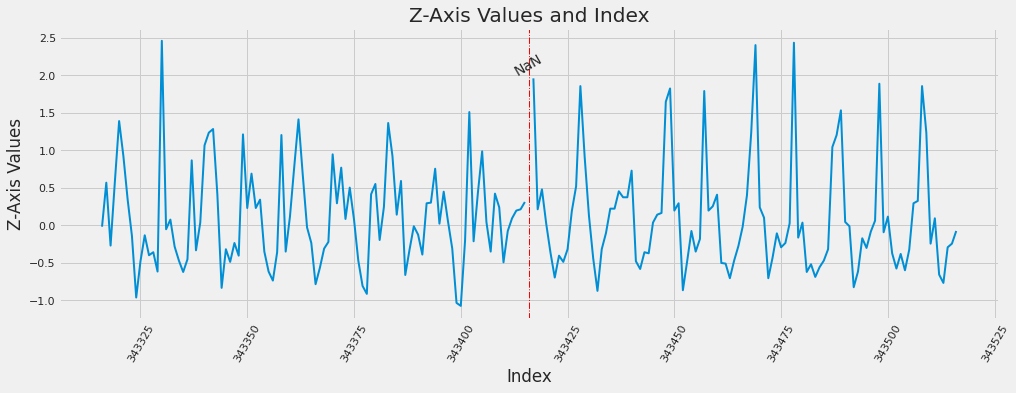

In [26]:
fig, ax = plt.subplots()

df_HAR.loc[int(null_index - 100) : int(null_index + 100),"z-axis"].plot(figsize = (15, 5), 
                                                                        use_index = True,
                                                                        linewidth=2,
                                                                        rot = 60,
                                                                        grid = True,
                                                                        ax=ax, 
                                                                        xlabel = 'Index',
                                                                        ylabel = 'Z-Axis Values',
                                                                        title = 'Z-Axis Values and Index')

ax.axvline(null_index, 
           color = "red", 
           linestyle = "-.", 
           linewidth = 1)

ax.annotate(s = "NaN", 
            xy = (null_index, 2), 
            xytext = (int(null_index-4), 2.0), 
            rotation = 30)


# reference : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

In [27]:
df_HAR.loc[null_index,'z-axis'] = 0.5

# df_HAR = df_HAR.replace({'z-axis': np.nan}, 2.0)

In [28]:
df_HAR[343415:343418]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
343415,11,Walking,1787072368000,-0.470557,0.196312,0.308901
343416,11,Walking,1867172313000,0.545642,-0.423296,0.500000
343417,11,Walking,1867222270000,0.703328,0.174077,1.959120


Grouping by User ID 11.

In [29]:
df_HAR_uid_11 =  df_HAR[df_HAR['user-id'] == 11]

In [30]:
df_HAR_uid_11

,user-id,activity,timestamp,x-axis,y-axis,z-axis
337217,11,Walking,1474122264000,-0.349372,0.452753,0.025269
337218,11,Walking,1474172252000,-0.269069,0.691406,-0.158089
337219,11,Walking,1474222301000,-0.393174,0.629148,-0.415935
337220,11,Walking,1474272258000,-0.409234,0.308968,-0.530534
337221,11,Walking,1474322307000,-0.645763,0.685476,-1.046228
...,...,...,...,...,...,...
556653,11,Jogging,57221172314000,-0.543559,-0.399579,-0.900497
556654,11,Jogging,57221222332000,-0.578601,-0.361039,-0.709084
556655,11,Jogging,57221272381000,-0.537719,-0.160926,-0.681739
556656,11,Jogging,57221322338000,-0.432595,0.065868,-0.972015


In [31]:
df_HAR_uid_11.groupby('activity')['z-axis'].mean()

activity
Downstairs    0.228669
Jogging      -0.550758
Upstairs      0.239299
Walking       0.072281
Name: z-axis, dtype: float32

Since the dataset has only 1 NaN value, the selected estimated value to replace the NaN value will not have much impact to the mean value of the z-axis while 'Walking'.

### Visualisation

#### Number of record samples (and its portions) for each activity.

In [32]:
df_HAR['activity'].value_counts()

# df_HAR['activity'].value_counts().to_frame()
# df_HAR['activity'].value_counts()[1]
# df_HAR.groupby('activity')['activity'].count()

Walking       424398
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

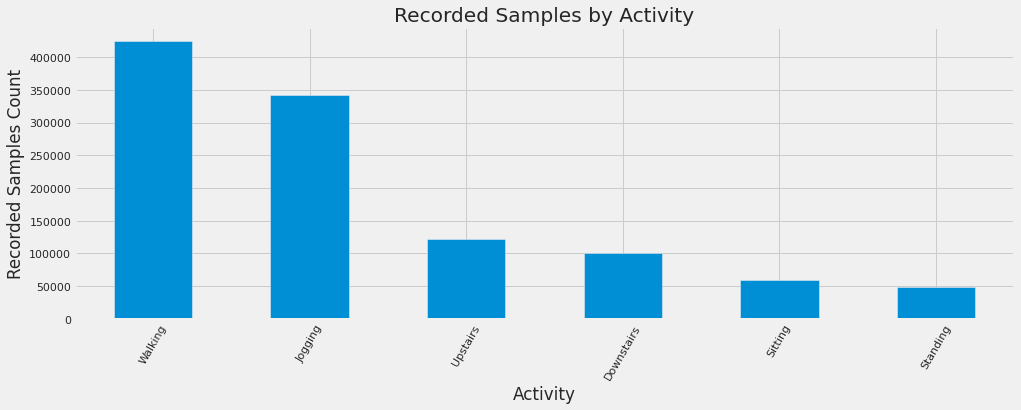

In [33]:
df_HAR['activity'].value_counts().plot(kind='bar',
                                       figsize = (15, 5),
                                       rot = 60,
                                       xlabel = 'Activity',
                                       ylabel = 'Recorded Samples Count',
                                       title = 'Recorded Samples by Activity')

plt.show()

# df_HAR.groupby('activity')['activity'].count().plot(kind = 'bar',
#                                                     title = 'Recorded Samples by Activity')

#### Number of record samples (and its portions) for User ID.

In [34]:
df_HAR['user-id'].nunique()

36

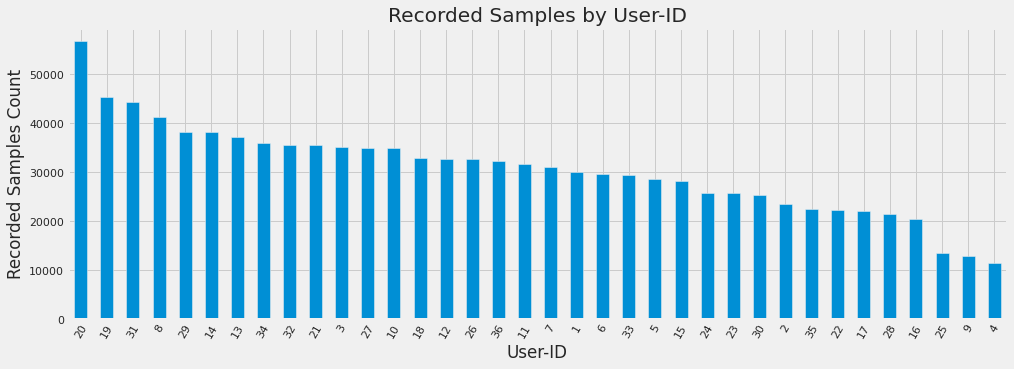

In [35]:
df_HAR['user-id'].value_counts().plot(kind='bar',
                                      figsize = (15, 5),
                                      rot = 60,
                                      xlabel = 'User-ID',
                                      ylabel = 'Recorded Samples Count',                                      
                                      title = 'Recorded Samples by User-ID')

plt.show()

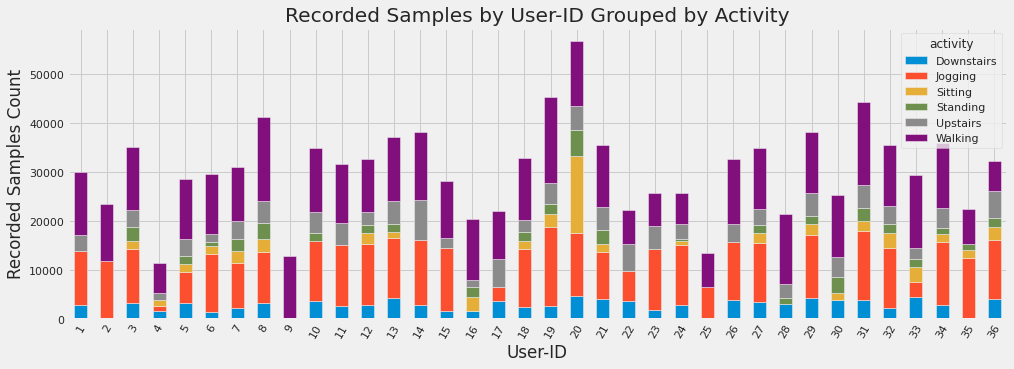

In [36]:
df_HAR.groupby(['user-id', 'activity']).size().unstack().plot(kind='bar', 
                                                              stacked=True, 
                                                              figsize = (15, 5),
                                                              rot = 60,
                                                              xlabel = 'User-ID',
                                                              ylabel = 'Recorded Samples Count',                                      
                                                              title = 'Recorded Samples by User-ID Grouped by Activity')

#### Accelerometers of X-Axis, Y-Axis, Z-Axis for each activity.

In [37]:
def axis_plot(ax, x, y, title):

  ax.plot(x, y, linewidth=2)
  ax.set_title(title)
  ax.xaxis.set_visible(False)
  ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
  ax.set_xlim([min(x), max(x)])
  # ax.grid(True)

def activity_plot(activity, df_dataset):

  fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex=True)
  
  axis_plot(ax0, df_dataset['timestamp'], df_dataset['x-axis'], 'X-Axis')
  print("")
  axis_plot(ax1, df_dataset['timestamp'], df_dataset['y-axis'], 'Y-Axis')
  print("")
  axis_plot(ax2, df_dataset['timestamp'], df_dataset['z-axis'], 'Z-Axis')  
  
  plt.subplots_adjust(hspace = 0.2)
  fig.suptitle(activity)
  plt.subplots_adjust(top = 0.9)

  plt.show()

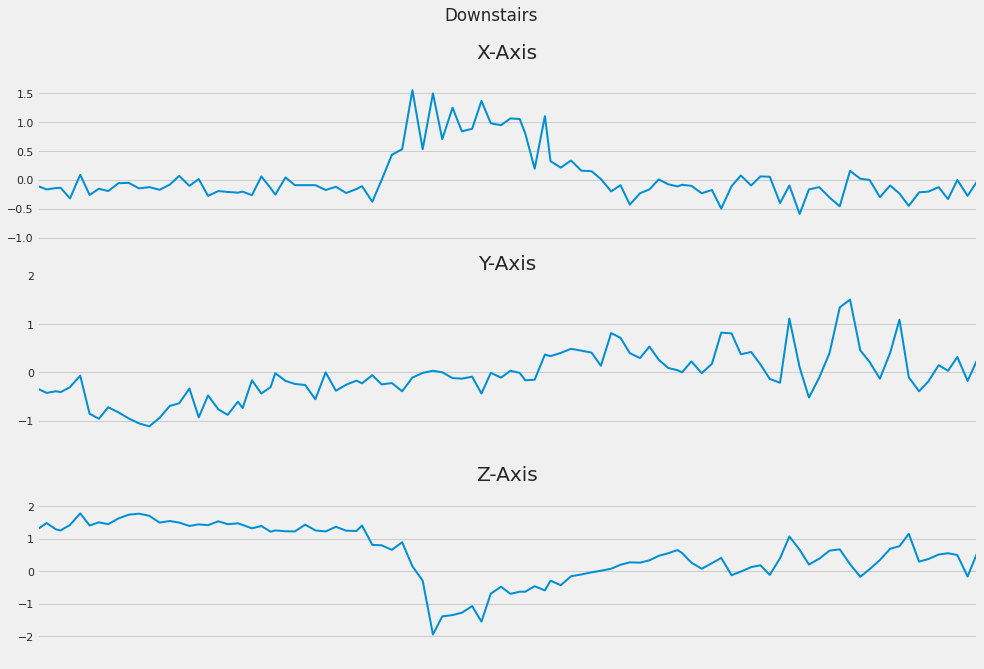

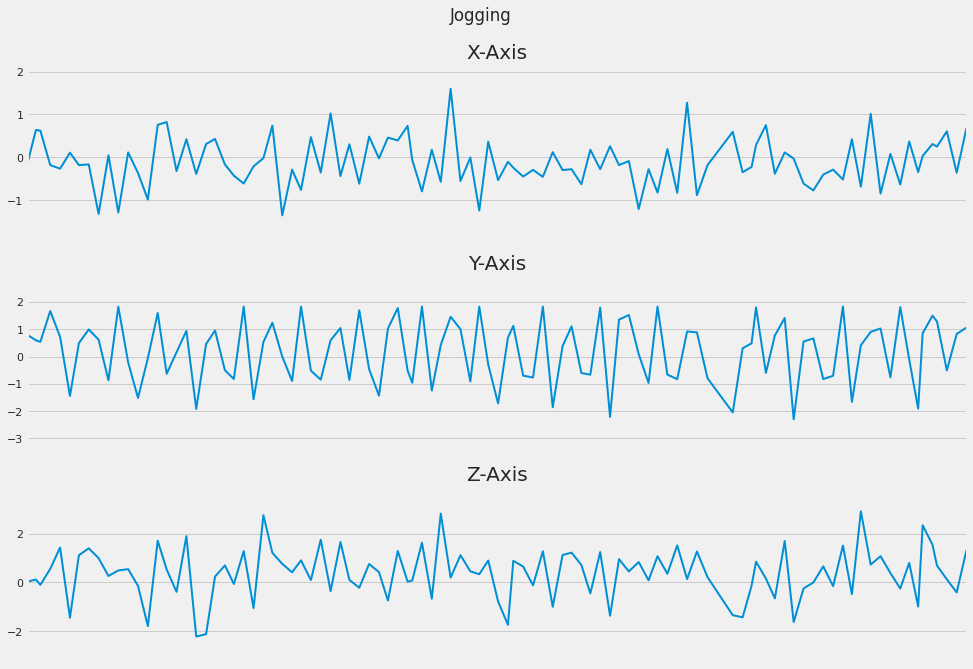

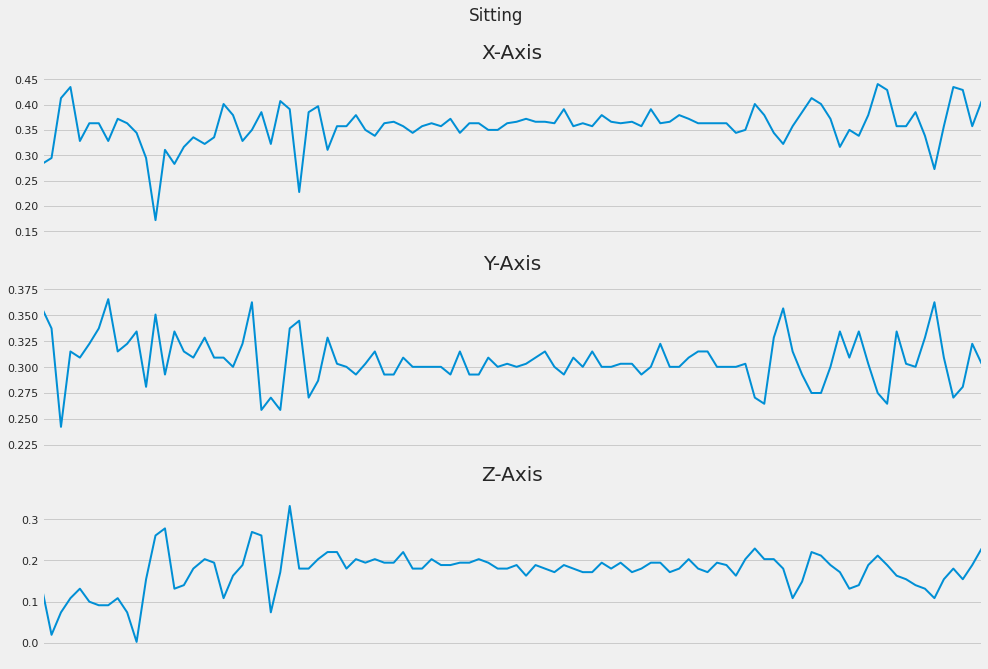

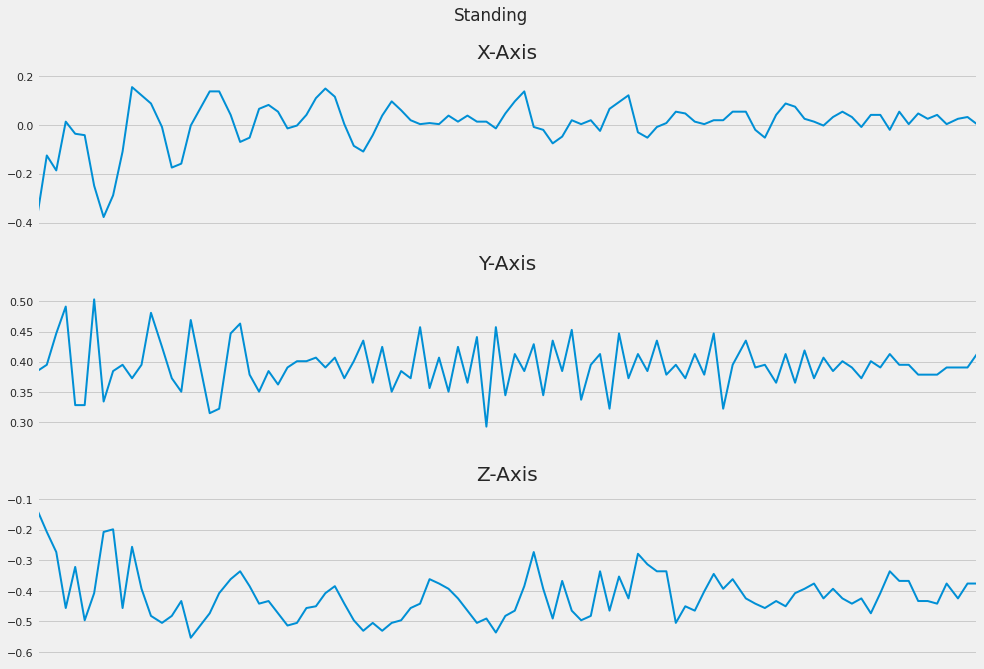

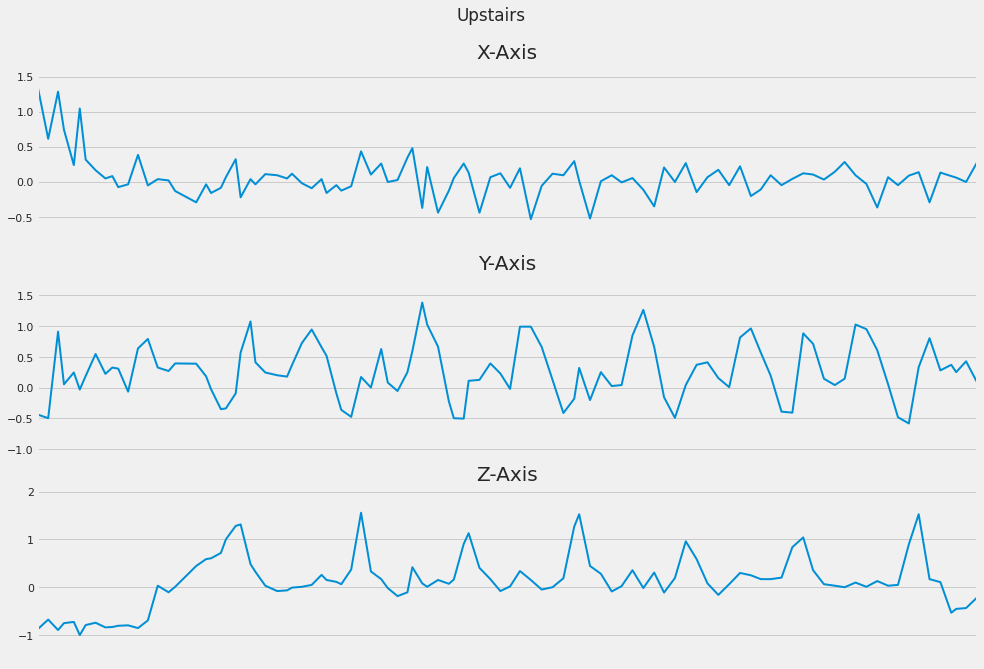

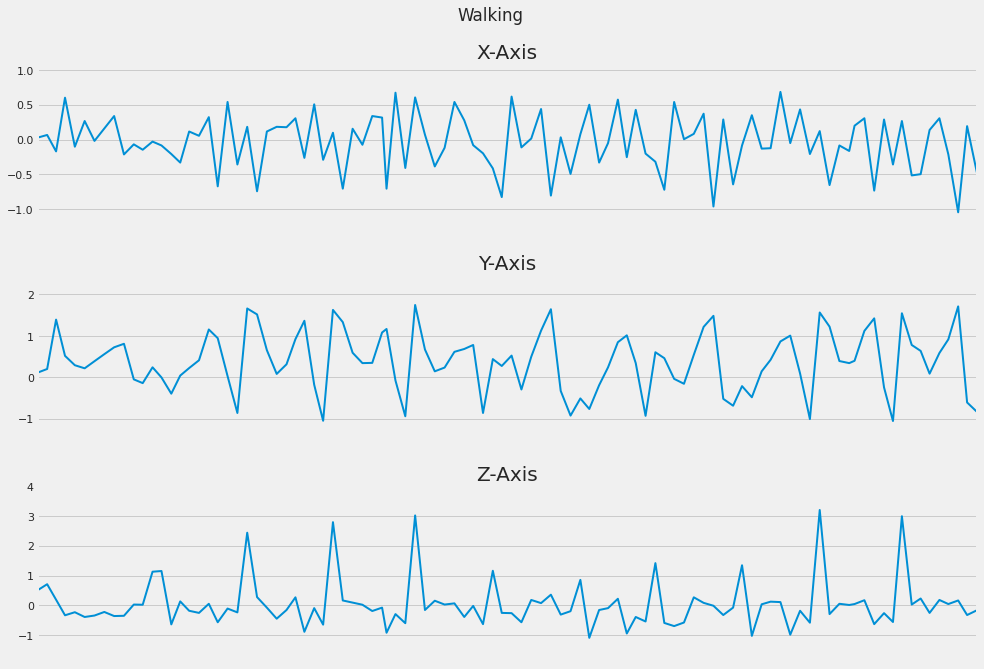

In [38]:
for activity in np.unique(df_HAR['activity']):
  subset = df_HAR[df_HAR['activity'] == activity][: 100]
  activity_plot(activity, subset)

## Confusion Matrix

Confusion matrix to be used later for evaluating prediction results.

In [39]:
def confusion_matrix(y_train, y_prediction):
  '''
  Confusion matrix
  '''

  matrix = metrics.confusion_matrix(y_train, y_prediction)

  plt.figure(figsize=(10,10))

  sns.heatmap(matrix,
              cmap = "coolwarm",
              linecolor = 'white',
              linewidths = 1,
              xticklabels = labels,
              yticklabels = labels,
              annot = True,
              fmt = 'd')
  
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  
  plt.show()

## Data Preparation

### Segmentations (Time-Sliced Representation)

In [40]:
labels = [x for x in np.unique(df_HAR['activity'])]
labels

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [41]:
label_encoded_activity = 'encoded-activity'
label_encoder = preprocessing.LabelEncoder()
df_HAR[label_encoded_activity] = label_encoder.fit_transform(df_HAR['activity'].values.ravel())

In [42]:
df_HAR.head(3)

,user-id,activity,timestamp,x-axis,y-axis,z-axis,encoded-activity
0,33,Jogging,49105962326000,-0.198203,0.804142,0.019539,1
1,33,Jogging,49106062271000,0.635039,0.594170,0.114083,1
2,33,Jogging,49106112167000,0.619130,0.537639,-0.103654,1


In [43]:
def segments_and_labels_creator(df_dataset, time_steps, steps, label_name):
  '''
  Convert dataframe and reshape segments of x-axis, y-axis, z-axis reconds together with its corresponding labels
  '''

  # x-axis, y-axis, z-axis
  feature_num = 3

  segments = []
  labels = []

  for i in range(0, len(df_dataset) - time_steps, steps):
    xs = df_dataset['x-axis'].values[i : i + time_steps]
    ys = df_dataset['y-axis'].values[i : i + time_steps]
    zs = df_dataset['z-axis'].values[i : i + time_steps]

    label = stats.mode(df_dataset[label_name][i : i + time_steps])[0][0]

    segments.append([xs, ys, zs])
    labels.append(label)
  
  segments_reshaped = np.asarray(segments, dtype = np.float32).reshape(-1, time_steps, feature_num)
  labels = np.asarray(labels)

  return segments_reshaped, labels

## Training & Testing Dataset

Constant values to be used later.

In [44]:
time_steps = 80
steps = 40

### Training dataset

Splitting training and testing datasets.

In [45]:
df_HAR_train = df_HAR[df_HAR['user-id'] <= 28]
df_HAR_test = df_HAR[df_HAR['user-id'] > 28]

In [46]:
x_train, y_train = segments_and_labels_creator(df_HAR_train, time_steps, steps, label_encoded_activity)

In [47]:
x_train.shape

(20868, 80, 3)

In [48]:
print(f'Training (x_train) dataset samples : {x_train.shape[0]}.')

# print('Training dataset samples are {sample}'.format(sample = x_train.shape[0]))

Training (x_train) dataset samples : 20868.


In [49]:
print(f'Training (y_train or label) dataset samples : {y_train.shape[0]}.')

Training (y_train or label) dataset samples : 20868.


In [50]:
time_steps, feature_num = x_train.shape[1], x_train.shape[2]
classes_num = label_encoder.classes_.size

print(list(label_encoder.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [51]:
x_train.shape

(20868, 80, 3)

#### Data input reshaping

Reviewing dataset **before (reshaping)**.

In [52]:
df_HAR_train[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,encoded-activity
8489,17,Walking,57869902574000,-0.013259,0.378140,-0.198198,5
8490,17,Walking,57870012316000,-0.096782,0.434671,-0.206793,5
8491,17,Walking,57870122301000,-0.130589,0.384197,-0.232578,5
8492,17,Walking,57870222246000,-0.074907,0.418520,-0.192468,5
8493,17,Walking,57870332292000,-0.074907,0.428615,-0.215388,5


In [53]:
x_train[:5]

array([[[-0.01325925, -0.0967824 , -0.13058938],
        [-0.07490729, -0.07490729, -0.00729331],
        [-0.08087323, -0.11269157, -0.10871428],
        ...,
        [-0.77978593, -0.02057035, -0.50474936],
        [-0.13516892, -0.4646398 , -0.59356326],
        [-0.13516892,  0.12267787,  0.9621124 ]],

       [[ 0.11600276,  0.12793463,  0.25520802],
        [ 0.45606127,  0.2770831 ,  0.12793463],
        [ 0.15577568,  0.02651368, -0.08485052],
        ...,
        [-0.95741373, -0.3127967 , -0.68237716],
        [-0.22398283,  0.02526908, -0.931629  ],
        [-0.21538793, -0.32712153,  1.0423315 ]],

       [[ 0.19952591,  0.25520802, -0.21411254],
        [ 0.25520802,  0.70861936,  0.33873114],
        [ 0.05435473,  0.17168485,  0.0145818 ],
        ...,
        [-0.94881886, -0.11797914, -0.04635503],
        [-0.15808864, -0.4646398 , -0.27841714],
        [-0.13516892,  0.44641882,  1.3889921 ]],

       [[-0.11269157, -0.28769246,  0.31685606],
        [ 0.41231108,  0

In [54]:
input_shape = (time_steps * feature_num)

x_train = x_train.reshape(x_train.shape[0], input_shape)

Reviewing dataset **after (reshaping)**.

In [55]:
x_train.shape

(20868, 240)

In [56]:
x_train[:5]

array([[-0.01325925, -0.0967824 , -0.13058938, ..., -0.13516892,
         0.12267787,  0.9621124 ],
       [ 0.11600276,  0.12793463,  0.25520802, ..., -0.21538793,
        -0.32712153,  1.0423315 ],
       [ 0.19952591,  0.25520802, -0.21411254, ..., -0.13516892,
         0.44641882,  1.3889921 ],
       [-0.11269157, -0.28769246,  0.31685606, ..., -0.19246821,
         0.64696634,  1.0652512 ],
       [ 0.1776508 ,  0.3069128 ,  0.159753  , ...,  0.02526908,
         1.0337366 , -0.5849683 ]], dtype=float32)

#### Converting datatypes

In [57]:
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

In [58]:
y_train[:5]

array([5., 5., 5., 5., 5.], dtype=float32)

#### One-Hot-Encoding labels

In [59]:
y_train = np_utils.to_categorical(y_train, classes_num)
y_train.shape

(20868, 6)

In [60]:
y_train[:5]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

### Testing dataset

Every steps from previous are performed in preparing testing dataset.

In [61]:
x_test, y_test = segments_and_labels_creator(df_HAR_test, time_steps, steps, label_encoded_activity)

Data input reshaping

In [62]:
x_test = x_test.reshape(x_test.shape[0], input_shape)

Converting datatypes

In [63]:
x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

In [64]:
y_test[:5]

array([1., 1., 1., 1., 1.], dtype=float32)

One-Hot-Encoding labels

In [65]:
y_test = np_utils.to_categorical(y_test, classes_num)

In [66]:
y_test[:5]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

## 1D Convolutional Neural Network (DNN - CNN)

### Modelling

In [67]:
input_tensor = Input(shape = (input_shape,))

x = Reshape((time_steps, feature_num))(input_tensor)

x = Conv1D(100, 10, activation = 'relu', kernel_regularizer = regularizers.L1(0.01), bias_regularizer = regularizers.L2(0.01))(x)
x = Conv1D(100, 10, activation = 'relu')(x)

x = Dropout(0.5)(x)

x = MaxPooling1D(3)(x)

x = Conv1D(160, 10, activation = 'relu')(x)
# x = Conv1D(160, 10, activation = 'relu')(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.7)(x)

output_tensor = Dense(6, activation = 'softmax')(x)

model_HAR = Model(input_tensor, output_tensor)
print(model_HAR.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 80, 3)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 71, 100)           3100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
dropout (Dropout)            (None, 62, 100)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 160)           160160

**Regularizers (i.e. kernel_regularizer = regularizers.L1(0.01), bias_regularizer = regularizers.L2(0.01)) for a Conv1d layer are introduced as to migitate overfitting.**

In [68]:
# model_HAR = Sequential()
# model_HAR.add(Reshape((time_steps, feature_num), input_shape = (input_shape,)))
# model_HAR.add(Conv1D(100, 10, activation = 'relu', input_shape = (time_steps, feature_num)))
# model_HAR.add(Conv1D(100, 10, activation = 'relu'))
# model_HAR.add(MaxPooling1D(3))
# model_HAR.add(Conv1D(160, 10, activation = 'relu'))
# model_HAR.add(Conv1D(160, 10, activation = 'relu'))
# model_HAR.add(GlobalAveragePooling1D())
# model_HAR.add(Dropout(0.5))
# model_HAR.add(Dense(classes_num, activation = 'softmax'))

# print(model_HAR.summary())
# # plot_model(model, to_file='convolutional_neural_network.png')

### Compilling

In [69]:
callbacks_list = [
      keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
      keras.callbacks.EarlyStopping(monitor ='accuracy', patience = 3)]

model_HAR.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

### Fitting

In [70]:
batch_size_ = 400
epoch_ = 50

In [71]:
history = model_HAR.fit(x_train,
                        y_train,
                        batch_size = batch_size_,
                        epochs = epoch_,
                        callbacks = callbacks_list,
                        validation_split = 0.2,
                        verbose = 1)

Epoch 1/50
42/42 [==============================] - 5s 60ms/step - loss: 1.6626 - accuracy: 0.6584 - val_loss: 1.0051 - val_accuracy: 0.7932
Epoch 2/50
42/42 [==============================] - 1s 29ms/step - loss: 0.8548 - accuracy: 0.7755 - val_loss: 0.7055 - val_accuracy: 0.8253
Epoch 3/50
42/42 [==============================] - 1s 30ms/step - loss: 0.6258 - accuracy: 0.8195 - val_loss: 0.6467 - val_accuracy: 0.8038
Epoch 4/50
42/42 [==============================] - 1s 28ms/step - loss: 0.5493 - accuracy: 0.8376 - val_loss: 0.6178 - val_accuracy: 0.8318
Epoch 5/50
42/42 [==============================] - 1s 30ms/step - loss: 0.4973 - accuracy: 0.8505 - val_loss: 0.5982 - val_accuracy: 0.8146
Epoch 6/50
42/42 [==============================] - 1s 29ms/step - loss: 0.4597 - accuracy: 0.8634 - val_loss: 0.5879 - val_accuracy: 0.8052
Epoch 7/50
42/42 [==============================] - 1s 29ms/step - loss: 0.4457 - accuracy: 0.8668 - val_loss: 0.5785 - val_accuracy: 0.8083
Epoch 8/50
42

### Training & Validation Results

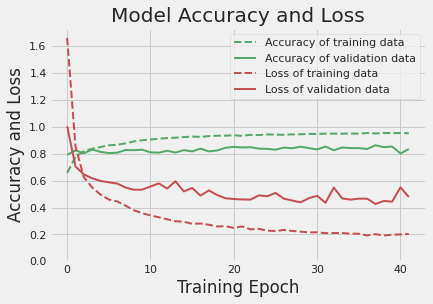

In [72]:
plt.figure(figsize=(6, 4))

plt.plot(history.history['accuracy'], "g--", linewidth=2, label = "Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", linewidth=2, label = "Accuracy of validation data")
plt.plot(history.history['loss'], "r--", linewidth=2, label = "Loss of training data")
plt.plot(history.history['val_loss'], "r", linewidth=2, label = "Loss of validation data")

plt.ylim(0)

plt.title('Model Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylabel('Accuracy and Loss')

plt.legend()
plt.show()

### Evaluation

In [73]:
score = model_HAR.evaluate(x_test, y_test, verbose=1)

206/206 [==============================] - 1s 5ms/step - loss: 0.3644 - accuracy: 0.9174


In [74]:
print(f'Accuracy on test data: {score[1]}')
print(f'Loss on test data: {score[0]}')

Accuracy on test data: 0.9173754453659058
Loss on test data: 0.3644181787967682


In [78]:
y_pred_test = model_HAR.predict(x_test)

# selecting the highest value (probability) from the test prediction results
argmax_y_pred_test = np.argmax(y_pred_test, axis=1)

# selecting the highest value from the test data
argmax_y_test = np.argmax(y_test, axis=1)

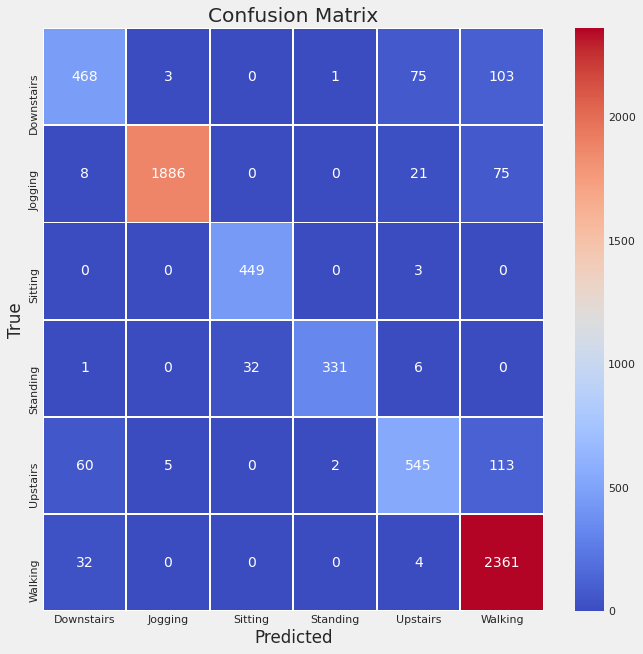

In [79]:
confusion_matrix(argmax_y_test, argmax_y_pred_test)

In [80]:
print(classification_report(argmax_y_test, argmax_y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       650
           1       1.00      0.95      0.97      1990
           2       0.93      0.99      0.96       452
           3       0.99      0.89      0.94       370
           4       0.83      0.75      0.79       725
           5       0.89      0.98      0.94      2397

    accuracy                           0.92      6584
   macro avg       0.91      0.88      0.89      6584
weighted avg       0.92      0.92      0.92      6584



## References & Credits

1. Jennifer R. Kwapisz, Gary M. Weiss and Samuel A. Moore (2010). 
Activity Recognition using Cell Phone Accelerometers, 
Proceedings of the Fourth International Workshop on Knowledge 
Discovery from Sensor Data (at KDD-10), Washington DC.

2. https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/ 

3. https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf